In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


date : Tue Oct  1 23:24:24 PDT 2019
hostname : sedna
nvidia-smi -L : GPU 0: GeForce GTX 1080 Ti (UUID: GPU-2d5cf167-db75-89ec-c6f7-5639237768ce)
pwd : /home/tmb/exp/icdar2019-worksheets


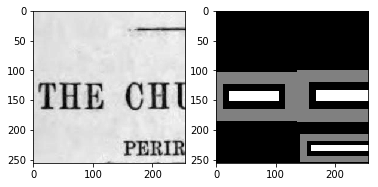

In [4]:
from importlib import reload

import os
import sys
import re
import glob
import time
import pickle
import scipy.ndimage as ndi
from itertools import islice
import IPython
import logging
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset
from ocrlib import ocrhelpers as helpers
from ocrlib.ocrhelpers import method, asnp
import matplotlib.pyplot as plt

plt.rc("image", cmap="gray")
plt.rc("image", interpolation="nearest")

    
transforms = [
    lambda x: (torch.tensor(x).float()/255.0).unsqueeze(0),
    lambda y: torch.tensor(y).long()
]
training = WebDataset("data/seg-{000000..000019}.tar", decoder="l8", 
                      extensions="image.png target.png", transforms=transforms)
training_dl = DataLoader(training, batch_size=5)

def RUN(x): print(x, ":", os.popen(x).read().strip())
    
RUN("date"); RUN("hostname"); RUN("nvidia-smi -L"); RUN("pwd")
images, targets, = next(iter(training_dl))
subplot(121); imshow(images[0,0]); subplot(122); imshow(targets[0])

In [3]:
model = models.make("seg_lstm", device="cpu")
epoch, loss = models.load_latest(model)

loading models/seg_lstm-001-000423499.pth


In [4]:
!gsutil cat gs://lpr-g1000-tess/Volume_0000.tgz | tarshow -c 3

__key__             	Volume_0000/Image_0000
__source__          	-
hocr                	b'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUB
jpeg                	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00

__key__             	Volume_0000/Image_0001
__source__          	-
hocr                	b'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUB
jpeg                	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00

__key__             	Volume_0000/Image_0002
__source__          	-
hocr                	b'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUB
jpeg                	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00



In [5]:
!test -f page.jpeg || gsutil cat gs://lpr-g1000-tess/Volume_0010.tgz | tarfirst -f jpeg -S '"0035" in _["__key__"]' > page.jpeg

(1627, 1019)


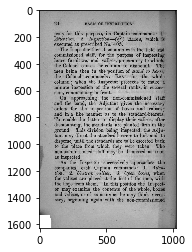

In [6]:
image = mean(imread("page.jpeg"), 2)/255.0
print(image.shape)
imshow(image)

In [7]:
import torch
input = torch.tensor(image).unsqueeze(0).unsqueeze(0)
input.order = "BDHW"
input.shape

torch.Size([1, 1, 1627, 1019])

In [8]:
output = model(input)

In [9]:
output.shape

torch.Size([1, 3, 1625, 1017])

In [10]:
probs = output.softmax(1)[0].cpu().permute(1, 2, 0).detach().numpy()
probs.shape

(1625, 1017, 3)

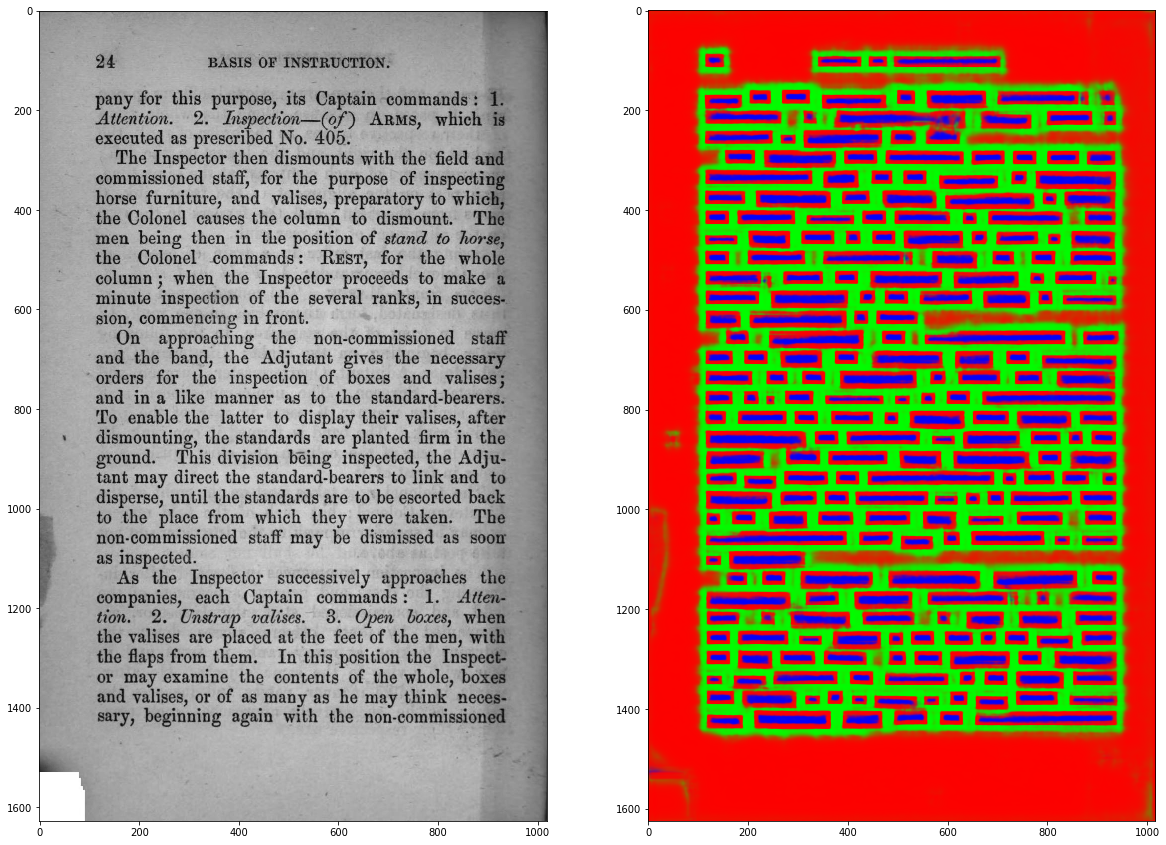

In [11]:
figsize(20, 20)
subplot(121); imshow(image);
subplot(122); imshow(probs)

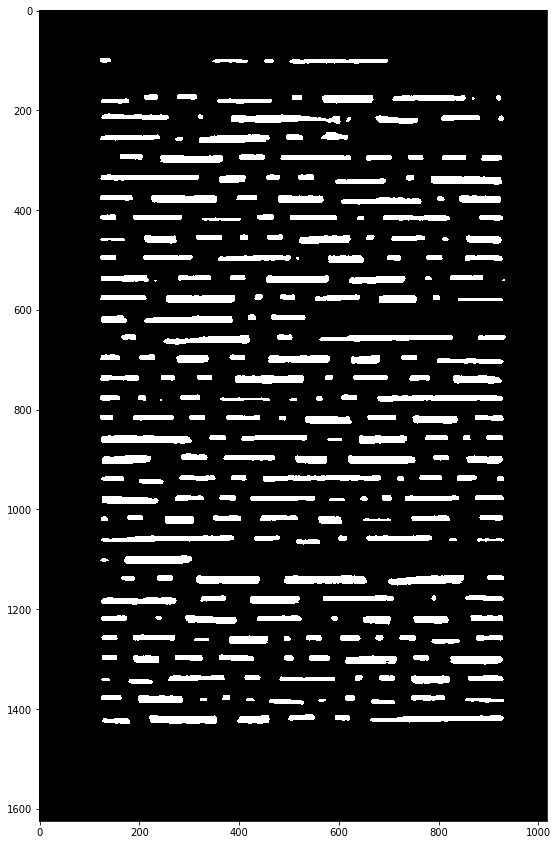

In [12]:
subplot(121); imshow(probs[:,:,2] > 0.5)

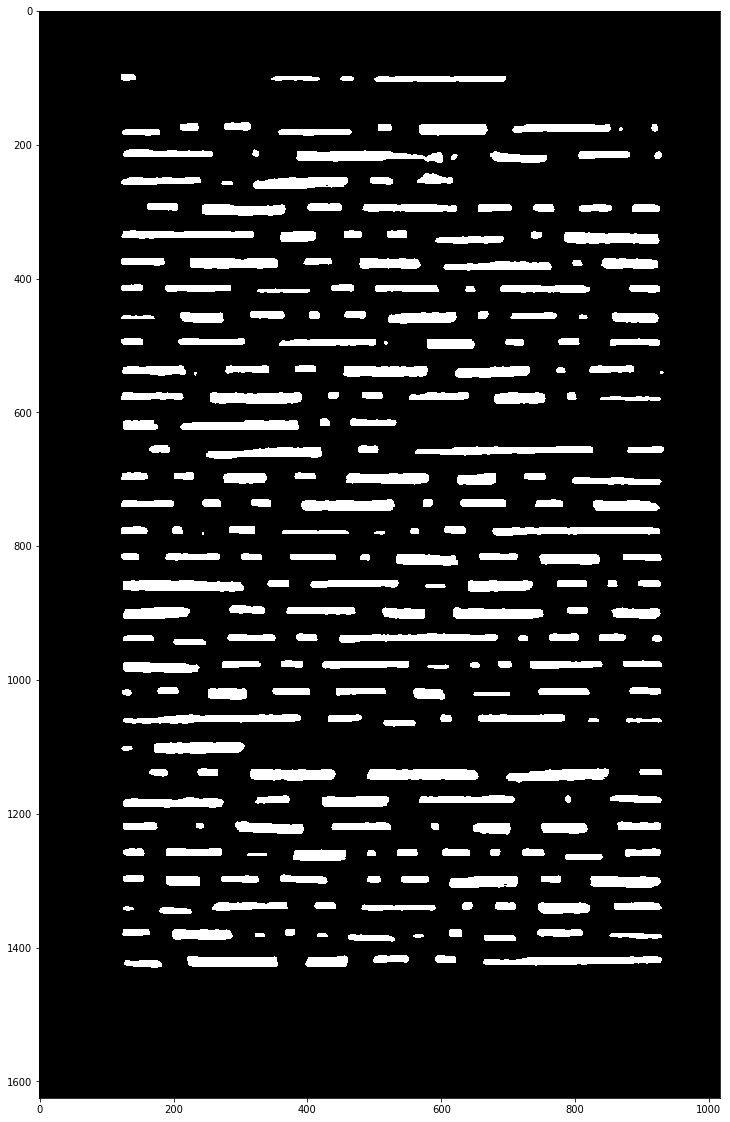

In [13]:
word_markers = (probs[:,:,2] > 0.5)
word_markers = ndi.minimum_filter(ndi.maximum_filter(word_markers, (1, 3)), (1, 3))
imshow(word_markers)

In [14]:
def show_seg(a):
    imshow(where(a==0, 0, 0.3+abs(sin(a))), cmap=cm.gnuplot)

250


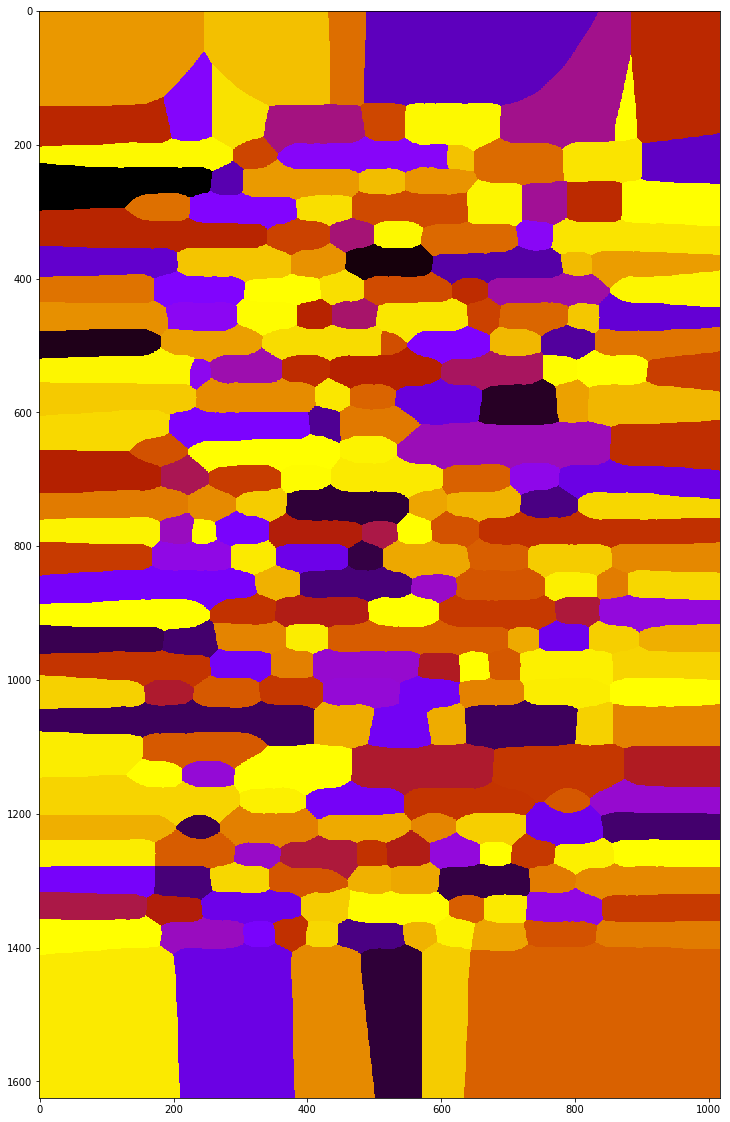

In [15]:
word_labels, n = ndi.label(word_markers)
print(n)
_, sources = ndi.distance_transform_edt(1-word_markers, return_indices=True)
word_sources = word_labels[sources[0], sources[1]]
show_seg(word_sources)

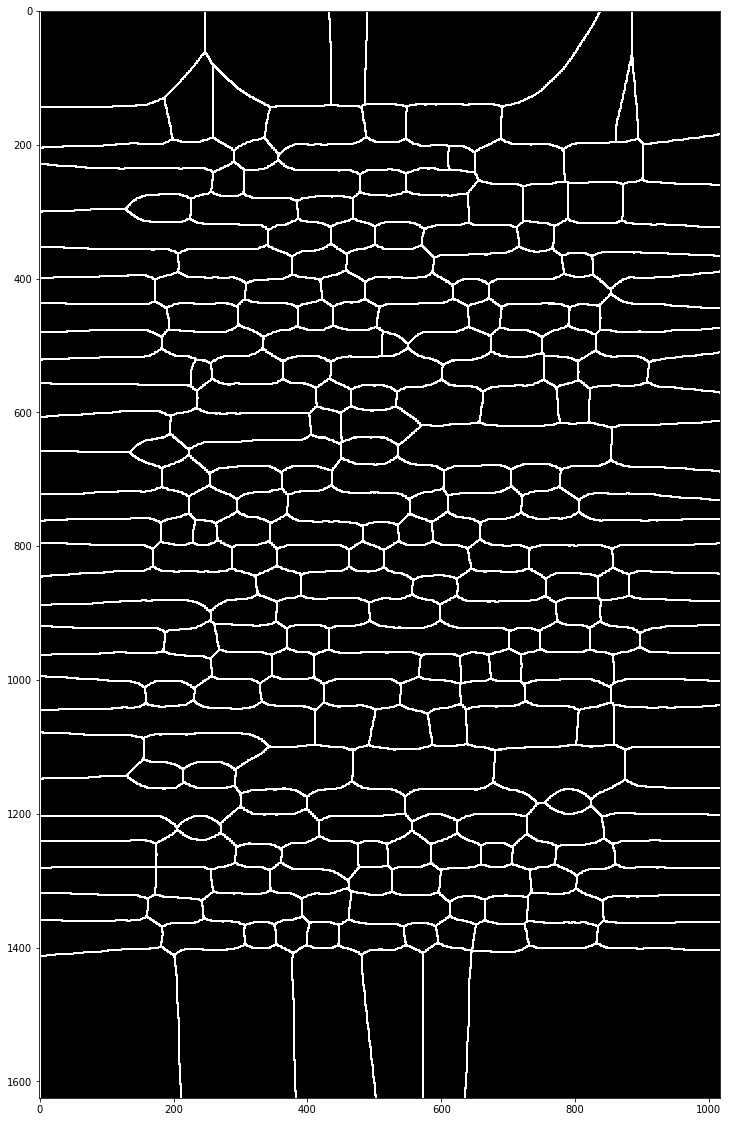

In [16]:
word_boundaries = maximum((roll(word_sources, 1, 0)!=word_sources), roll(word_sources, 1, 1)!=word_sources)
word_boundaries = ndi.minimum_filter(ndi.maximum_filter(word_boundaries, 4), 2)
imshow(word_boundaries)

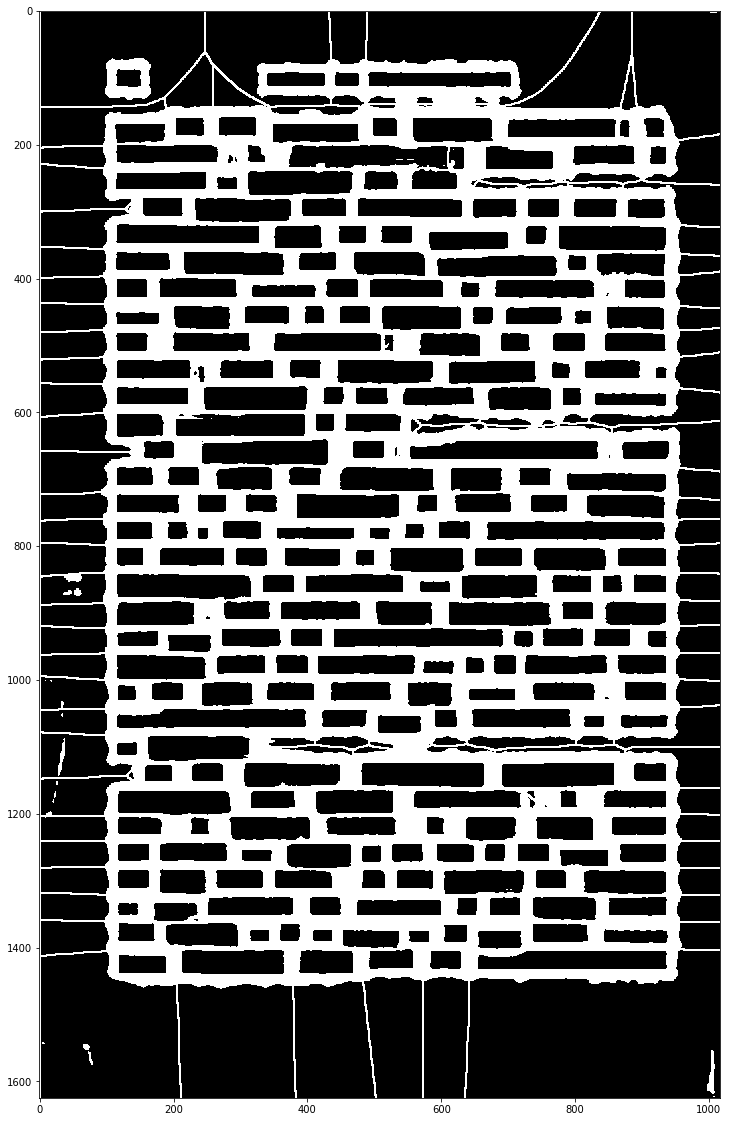

In [17]:
separators = maximum(probs[:,:,1]>0.3, word_boundaries)
imshow(separators)

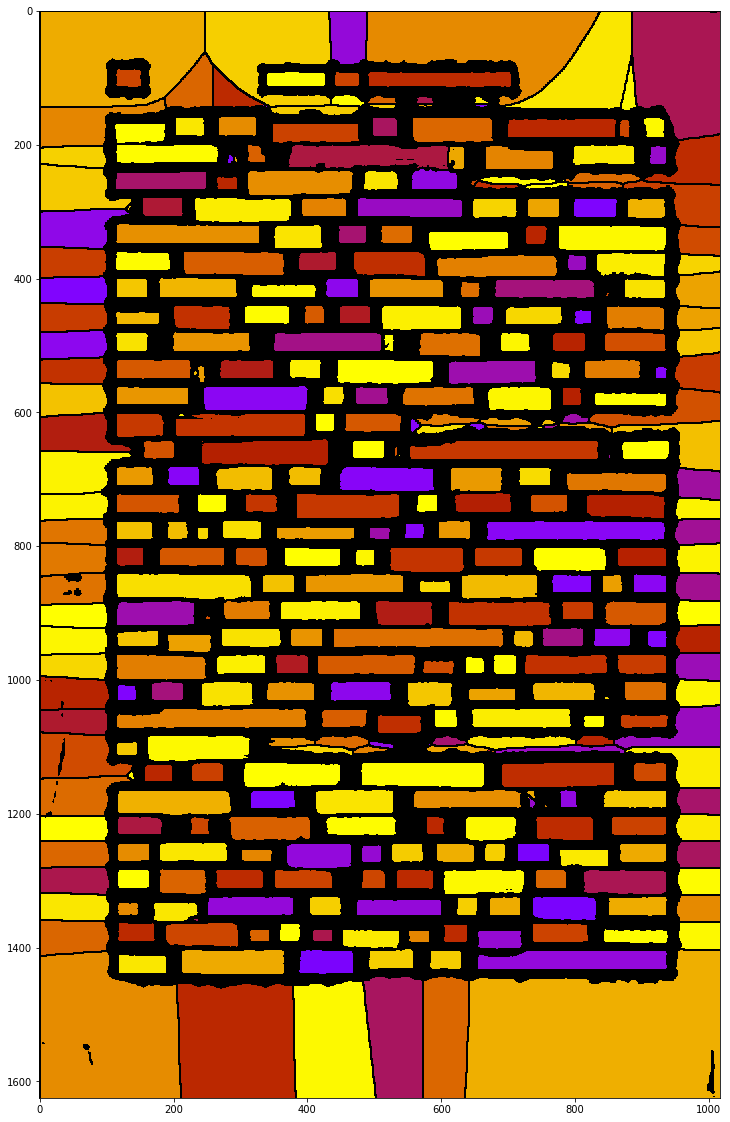

In [18]:
all_components, n = ndi.label(1-separators)
show_seg(all_components)

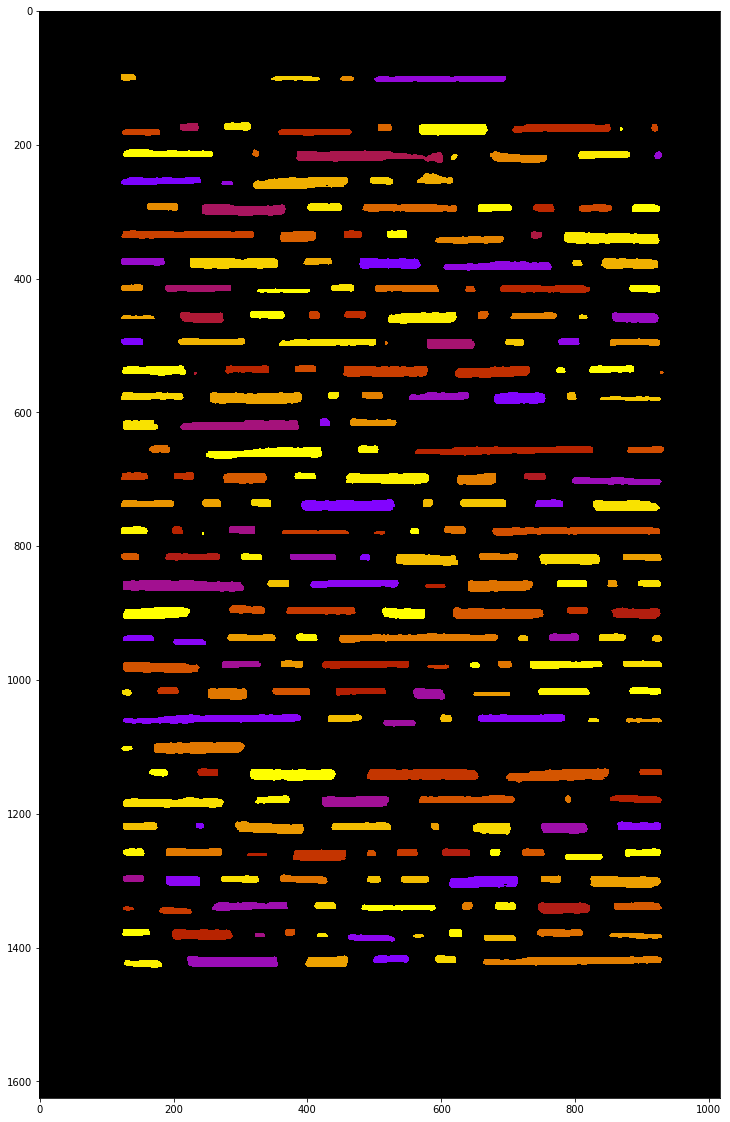

In [19]:
word_markers = (probs[:,:,2] > 0.5) * (1-separators)
word_markers = ndi.minimum_filter(ndi.maximum_filter(word_markers, (1, 3)), (1, 3))
word_labels, n = ndi.label(word_markers)
show_seg(word_labels)

In [23]:
correspondence = 1000000 * word_labels + all_components
nwords = amax(word_sources)+1
ncomponents = amax(all_components)+1

In [24]:
wordmap = zeros(ncomponents, dtype=int)
for word, comp in [(k//1000000, k%1000000) for k in unique(correspondence.ravel())]:
    if comp==0: continue
    if word==0: continue
    if wordmap[comp]>0: print(word, comp)
    wordmap[comp] = word

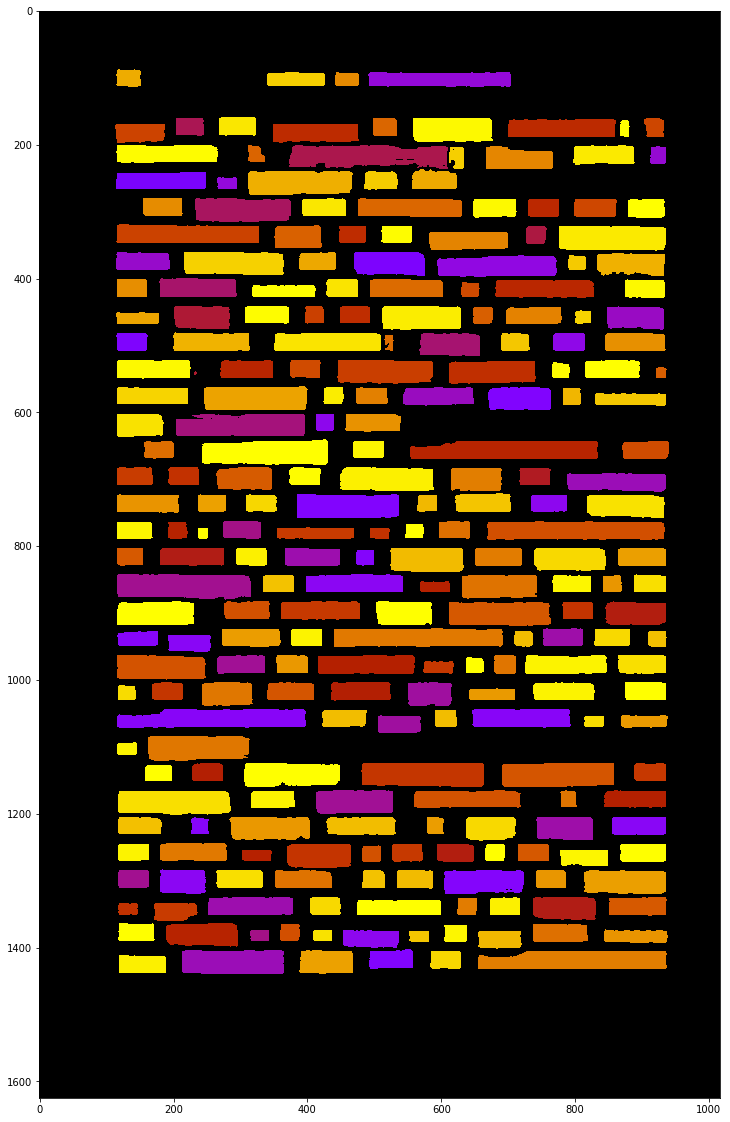

In [25]:
result = wordmap[all_components]
show_seg(result)

In [47]:
def slpad(sl, r):
    if isinstance(r, int):
        return slice(max(sl.start-r, 0), sl.stop+r)
    elif isinstance(r, float):
        d = int((0.5+sl.stop-sl.start)*r)
        return slice(max(sl.start-d, 0), sl.stop+d)
    else:
        raise ValueError(f"range {r}")

def slspad(sls, rs):
    if not isinstance(rs, list):
        rs = [rs]*len(sls)
    return tuple(slpad(x, r) for x, r in zip(sls, rs))

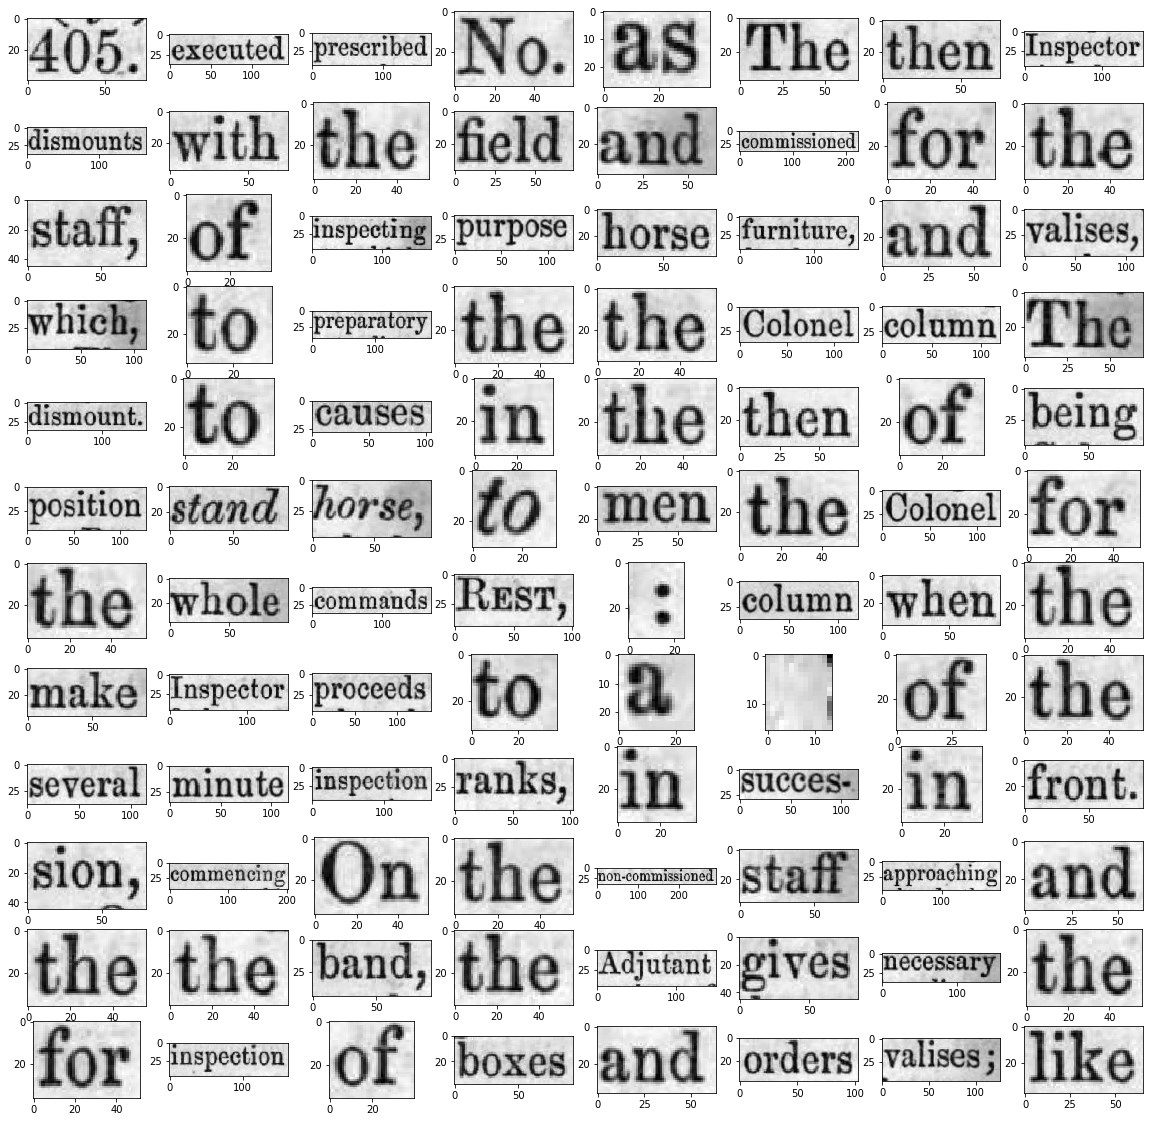

In [52]:
import itertools as itt
for i, sl in enumerate(itt.islice(ndi.find_objects(result), 20, 200)):
    if i>=96: break
    region = slspad(sl, 5)
    #print(region)
    #continue
    subplot(12, 8, i+1)
    imshow(image[region])